In [4]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Wczytanie modelu i tokenizerów
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
labels = {0:'negative', 1:'neutral', 2:'positive'}

# Wczytanie 1000 losowych wierszy z CSV
df = pd.read_csv("test_dataset.csv").reset_index(drop=True)

# Funkcja klasyfikująca tekst
def classify_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True,
        max_length=512).to(device)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output.logits[0].detach().cpu().numpy()
    scores = softmax(scores)
    return "Positive" if scores[0]< scores[2] else "Negative"

df = df[df['review_text'].notnull()]  
df['predicted_label'] = df['review_text'].apply(classify_sentiment)

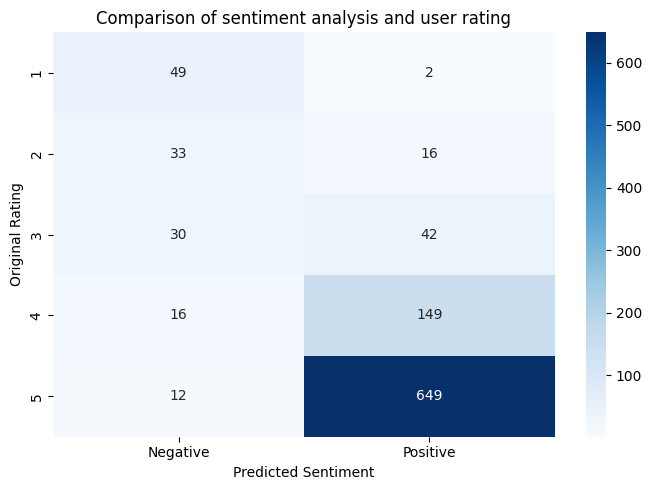

In [18]:
pivot = pd.crosstab(df['rating'], df['predicted_label'])
plt.figure(figsize=(7, 5))
sns.heatmap(pivot, annot=True, fmt='d', cmap='Blues')
plt.title('Comparison of sentiment analysis and user rating')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Original Rating')
plt.tight_layout()
plt.show()

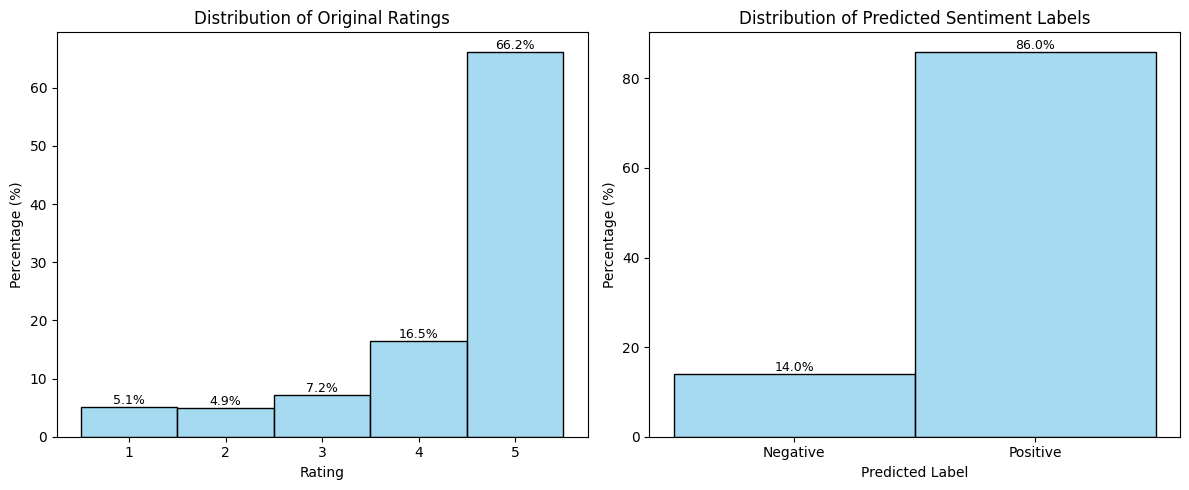

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Histogram oryginalnych ratingów (z normalizacją do procentów)
plt.subplot(1, 2, 1)
ax1 = sns.histplot(df['rating'], discrete=True, stat='percent', color='skyblue')
ax1.set_title('Distribution of Original Ratings')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Percentage (%)')

# Dodanie wartości procentowych na słupkach
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=9)

# Histogram predykcji sentymentu (z normalizacją do procentów)
plt.subplot(1, 2, 2)
df['predicted_label'] = pd.Categorical(df['predicted_label'], categories=['Negative',  'Positive'], ordered=True)
ax2 = sns.histplot(df['predicted_label'], stat='percent', color='skyblue')
ax2.set_title('Distribution of Predicted Sentiment Labels')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('Percentage (%)')

for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df['submission_time'], format='%Y-%m-%d')
df_filtered = df[df['predicted_label'].isin(['negative', 'positive'])].copy()

df_filtered['time_bin'] = pd.cut(df_filtered['date'], bins=20)

counts = df_filtered.groupby(['time_bin', 'predicted_label'], observed=False).size().unstack(fill_value=0)


counts['neg_to_pos_ratio'] = counts['negative'] / (counts['positive']+counts['negative'])
counts['neg_to_pos_ratio'] = counts['neg_to_pos_ratio']

bin_right_edges = counts.index.map(lambda x: x.right)

plt.figure(figsize=(10, 5))
plt.plot(bin_right_edges, counts['neg_to_pos_ratio'], marker='o')
plt.title('Change of Negative Opinion Ratio Over Time (20 equal time intervals)')
plt.xlabel('Time (right edge of interval)')
plt.xticks(bin_right_edges)
plt.ylabel('Negative Opinion Ratio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Cannot cut empty array

Tu jest plan by można było tak agregować po dowolnym id np sklep, uzytkownik kategoria produktów

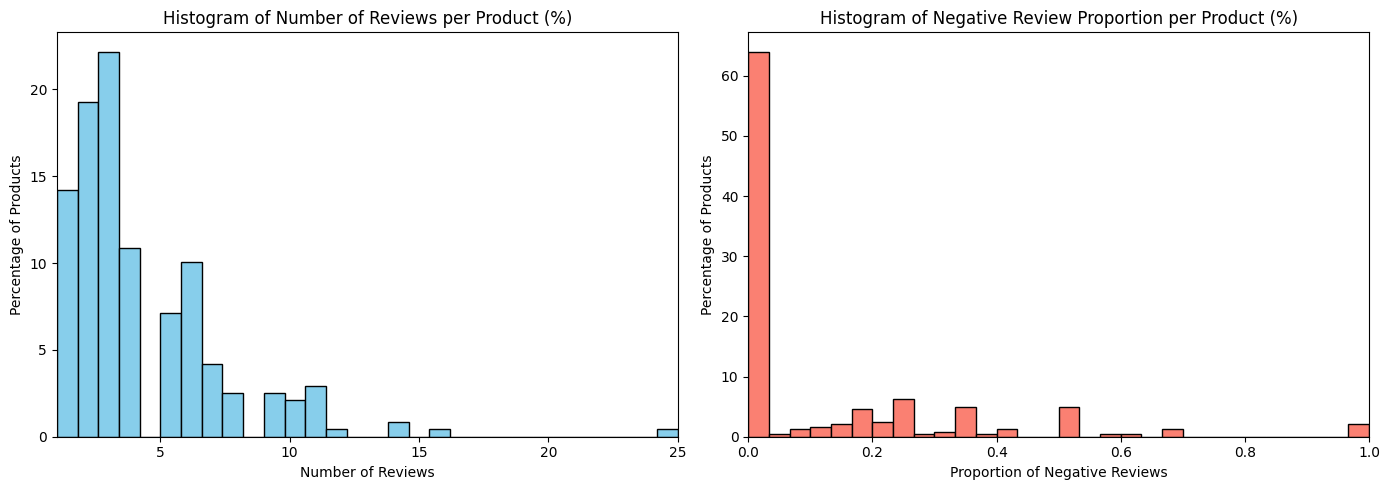

In [54]:
import matplotlib.pyplot as plt
import numpy as np

grouped = df.groupby('product_id')

reviews_count = grouped.size()
negative_count = df.groupby('product_id')['predicted_label'].apply(lambda x: (x == 'negative').sum())
negative_ratio = negative_count / reviews_count

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram liczby opinii - procentowy
counts, bins = np.histogram(reviews_count, bins=30)
percentages = counts / counts.sum() * 100

axes[0].bar(bins[:-1], percentages, width=np.diff(bins), align='edge', color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Number of Reviews per Product (%)')
axes[0].set_xlabel('Number of Reviews')
axes[0].set_ylabel('Percentage of Products')
axes[0].set_xlim(bins[0], bins[-1])

# Histogram proporcji negatywnych opinii - procentowy
counts2, bins2 = np.histogram(negative_ratio, bins=30)
percentages2 = counts2 / counts2.sum() * 100

axes[1].bar(bins2[:-1], percentages2, width=np.diff(bins2), align='edge', color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Negative Review Proportion per Product (%)')
axes[1].set_xlabel('Proportion of Negative Reviews')
axes[1].set_ylabel('Percentage of Products')
axes[1].set_xlim(bins2[0], bins2[-1])

plt.tight_layout()
plt.show()


In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

df['tokens'] = df['review_text'].apply(preprocess)

def unique_words_for_label(df, label, n=10):
    # Tokeny z danej klasy
    tokens_in_label = df[df['predicted_label'] == label]['tokens'].sum()
    counter_label = Counter(tokens_in_label)
    
    # Tokeny ze wszystkich innych klas
    tokens_other = df[df['predicted_label'] != label]['tokens'].sum()
    set_other = set(tokens_other)
    
    # Filtrujemy słowa unikatowe dla danej klasy
    unique_words = {word: freq for word, freq in counter_label.items() if word not in set_other}
    
    # Sortujemy i wybieramy top n
    top_unique = sorted(unique_words.items(), key=lambda x: x[1], reverse=True)[:n]
    
    return top_unique

for label in df['predicted_label'].unique():
    print(f"Top unique words for label '{label}':")
    print(unique_words_for_label(df, label))
    print()

Top unique words for label 'Negative':
[('waste', 4), ('disappointing', 4), ('jelly', 4), ('ai', 4), ('peau', 4), ('unscented', 3), ('masque', 3), ('stung', 3), ('trust', 3), ('tugging', 3)]

Top unique words for label 'Positive':
[('highly', 41), ('quickly', 31), ('absorbs', 27), ('moisturized', 25), ('happy', 24), ('everything', 24), ('nose', 23), ('facial', 21), ('instantly', 21), ('easily', 21)]



In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from PIL import Image
import io
import base64

# ------ NLTK downloads (odkomentuj przy pierwszym uruchomieniu) ------
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

# ------ Przygotowanie danych przykładowych (zastąp własnym df) ------
# df = pd.read_csv(...) # wczytaj swój DataFrame z kolumnami: rating, predicted_label, review_text, submission_time, product_id
# Zakładam, że df ma kolumny: 'rating', 'predicted_label', 'review_text', 'submission_time', 'product_id'

# ------ Funkcje preprocessingu ------
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = nltk.word_tokenize(str(text).lower())
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return tokens

df['tokens'] = df['review_text'].apply(preprocess)

# ------ Funkcja unikalnych słów ------
def unique_words_for_label(df, label, n=50):
    tokens_in_label = df[df['predicted_label'] == label]['tokens'].sum()
    counter_label = Counter(tokens_in_label)
    tokens_other = df[df['predicted_label'] != label]['tokens'].sum()
    set_other = set(tokens_other)
    unique_words = {word: freq for word, freq in counter_label.items() if word not in set_other}
    top_unique = sorted(unique_words.items(), key=lambda x: x[1], reverse=True)[:n]
    return dict(top_unique)

labels = df['predicted_label'].dropna().unique()

pivot = pd.crosstab(df['rating'], df['predicted_label'])
custom_blues = [
    [0, '#0a1e3f'],   # ciemny granat
    [0.25, '#274b7c'], 
    [0.5, '#3b6ebd'], 
    [0.75, '#5a90e7'], 
    [1, '#8ab9ff']    # jasny błękit
]

heatmap_fig = go.Figure(data=go.Heatmap(
    z=pivot.values,
    x=pivot.columns,
    y=pivot.index.astype(str),
    colorscale=custom_blues,
    text=pivot.values,
    texttemplate="%{text}",
    showscale=False  # usuwa pasek kolorów po prawej
))

heatmap_fig.update_layout(
    title="Comparison of sentiment analysis and user rating",
    xaxis_title="Predicted Sentiment",
    yaxis_title="Original Rating",
    template="plotly_dark",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)
\

# ------ Histogramy oryginalnych ratingów i predykcji (w jednej figurze jako 2 słupki obok) ------
rating_counts = df['rating'].value_counts(normalize=True).sort_index() * 100
pred_counts = df['predicted_label'].value_counts(normalize=True).sort_index() * 100

hist_fig = go.Figure()
hist_fig.add_trace(go.Bar(
    x=rating_counts.index.astype(str),
    y=rating_counts.values,
    name='Original Ratings',
    marker_color='skyblue',
    text=[f"{v:.1f}%" for v in rating_counts.values],
    textposition='auto'
))
hist_fig.add_trace(go.Bar(
    x=pred_counts.index.astype(str),
    y=pred_counts.values,
    name='Predicted Sentiment',
    marker_color='salmon',
    text=[f"{v:.1f}%" for v in pred_counts.values],
    textposition='auto'
))
hist_fig.update_layout(
    barmode='group',
    title="Distribution of Original Ratings and Predicted Sentiment Labels",
    xaxis_title="Category",
    yaxis_title="Percentage (%)",
    template="plotly_dark"
)

# ------ Trend zmiany neg/pos ratio w czasie ------
df['date'] = pd.to_datetime(df['submission_time'], errors='coerce')
df_filtered = df[df['predicted_label'].isin(['Negative', 'Positive'])].copy()
df_filtered['time_bin'] = pd.cut(df_filtered['date'].dropna(), bins=20)

counts = df_filtered.groupby(['time_bin', 'predicted_label']).size().unstack(fill_value=0)
counts['neg_to_pos_ratio'] = counts['Negative'] / (counts['Negative'] + counts['Positive'])

bin_right_edges = counts.index.map(lambda x: x.right if pd.notnull(x) else None)

trend_fig = go.Figure()
trend_fig.add_trace(go.Scatter(
    x=bin_right_edges,
    y=counts['neg_to_pos_ratio'],
    mode='lines+markers',
    line=dict(color='lightcoral'),
    name='Negative Opinion Ratio'
))
trend_fig.update_layout(
    title="Change of Negative Opinion Ratio Over Time (20 equal time intervals)",
    xaxis_title="Time (right edge of interval)",
    yaxis_title="Negative Opinion Ratio",
    template="plotly_dark",
    xaxis_tickangle=45
)

# ------ Histogramy dla produktów (liczba opinii i proporcja negatywnych) ------
grouped = df.groupby('product_id')
reviews_count = grouped.size()
negative_count = df.groupby('product_id')['predicted_label'].apply(lambda x: (x=='Negative').sum())
negative_ratio = negative_count / reviews_count

product_fig = make_subplots(rows=1, cols=2, subplot_titles=[
    "Histogram of Number of Reviews per Product (%)",
    "Histogram of Negative Review Proportion per Product (%)"
])

# Histogram liczby opinii %
counts, bins = np.histogram(reviews_count, bins=30)
percentages = counts / counts.sum() * 100

product_fig.add_trace(go.Bar(
    x=bins[:-1],
    y=percentages,
    width=np.diff(bins),
    marker_color='skyblue',
    name='Reviews Count %',
    showlegend=False
), row=1, col=1)

product_fig.update_xaxes(title_text="Number of Reviews", row=1, col=1)
product_fig.update_yaxes(title_text="Percentage of Products", row=1, col=1)

# Histogram proporcji negatywnych opinii %
counts2, bins2 = np.histogram(negative_ratio.dropna(), bins=30)
percentages2 = counts2 / counts2.sum() * 100

product_fig.add_trace(go.Bar(
    x=bins2[:-1],
    y=percentages2,
    width=np.diff(bins2),
    marker_color='salmon',
    name='Negative Ratio %',
    showlegend=False
), row=1, col=2)

product_fig.update_xaxes(title_text="Proportion of Negative Reviews", row=1, col=2)
product_fig.update_yaxes(title_text="Percentage of Products", row=1, col=2)

product_fig.update_layout(
    title_text="Product Review Statistics",
    template="plotly_dark",
    bargap=0.1,
    height=400,
    width=900
)

import plotly.graph_objects as go

# Grupowanie i obliczanie proporcji negatywnych opinii
grouped = df.groupby('product_id')
reviews_count = grouped.size()
negative_count = grouped['predicted_label'].apply(lambda x: (x == 'Negative').sum())
negative_ratio = (negative_count / reviews_count).fillna(0)

# Wybór top 10 produktów o najwyższej proporcji negatywnych opinii
top_negative_products = negative_ratio.sort_values(ascending=False).head(15).reset_index()
top_negative_products.columns = ['product_id', 'negative_ratio']

# Zaokrąglenie wartości do 3 miejsc po przecinku (opcjonalnie)
top_negative_products['negative_ratio'] = top_negative_products['negative_ratio'].round(3)

# Tworzenie tabeli w Plotly
table_fig = go.Figure(data=[go.Table(
    header=dict(
        values=["Product ID", "Negative Review Ratio"],
        fill_color='#1f2c56',
        font=dict(color='white', size=12),
        align='left'
    ),
    cells=dict(
        values=[top_negative_products['product_id'], top_negative_products['negative_ratio']],
        fill_color='#2c3e5e',
        font=dict(color='white', size=11),
        align='left'
    )
)])

table_fig.update_layout(
    template='plotly_dark',
    title="Top 10 Products by Negative Review Ratio"
)



# ------ WordCloud - generowanie obrazków chmur słów ------

def generate_wordcloud_image(freq_dict):
    wc = WordCloud(width=400, height=300, background_color=None, mode="RGBA", colormap='coolwarm')
    wc.generate_from_frequencies(freq_dict)
    img = wc.to_image()
    buffer = io.BytesIO()
    img.save(buffer, format='PNG')
    encoded = base64.b64encode(buffer.getvalue()).decode()
    return "data:image/png;base64," + encoded

wordcloud_images = {}
for label in labels:
    freqs = unique_words_for_label(df, label, n=100)
    wordcloud_images[label] = generate_wordcloud_image(freqs)

# ------ Funkcja do dodawania chmury słów do subplotu z odpowiednim ukryciem osi ------

import plotly.graph_objects as go
from plotly.subplots import make_subplots

def add_wordcloud_to_subplot(fig, img_array, row, col):
    # img_array musi być numpy array obrazu RGB
    fig.add_trace(go.Image(z=img_array), row=row, col=col)
    # Wyłącz osie i siatkę
    fig.update_xaxes(showgrid=False, zeroline=False, visible=False, row=row, col=col, range=[0, img_array.shape[1]])
    fig.update_yaxes(showgrid=False, zeroline=False, visible=False, row=row, col=col, range=[0, img_array.shape[0]], scaleanchor="x")

# Ustawienia raportu - 3 kolumny, 3 rzędy (ostatni rząd na chmury słów)
wc_cols = 3
wc_rows = 1  # np. 2 chmury słów -> 1 wiersz, 3 kolumny

report_fig = make_subplots(
    rows=3, cols=3,
    specs=[
        [{"type":"heatmap"}, {"type":"bar"}, {"type":"scatter"}],
        [{"type":"bar"}, {"type":"bar"}, {"type": "domain"}],
        [{"type":"image"}, {"type":"image"}, None],
    ],

    subplot_titles=[
        "Comparison of sentiment analysis and user rating",
        "Distribution of Ratings and Predicted Sentiment",
        "Change of Negative Opinion Ratio Over Time",
        "Number of Reviews per Product (%)",
        "Negative Review Proportion per Product (%)",
        "Top Products by Negative Review Ratio",
        "Unique Words: Negative",
        "Unique Words: Positive",
        None,
    ],
    column_widths=[0.33, 0.33, 0.34],
    row_heights=[0.3, 0.3, 0.4],
    horizontal_spacing=0.05,
    vertical_spacing=0.08,
)

# Dodajemy wykresy do raportu (przykład, podmień swoje figury)
for trace in heatmap_fig.data:
    report_fig.add_trace(trace, row=1, col=1)

for trace in hist_fig.data:
    report_fig.add_trace(trace, row=1, col=2)

for trace in trend_fig.data:
    report_fig.add_trace(trace, row=1, col=3)

for i, trace in enumerate(product_fig.data):
    col = 1 if i == 0 else 2
    report_fig.add_trace(trace, row=2, col=col)

for trace in table_fig.data:
    report_fig.add_trace(trace, row=2, col=3)


# Dodajemy chmury słów (wordcloud_images[label] = numpy array obrazu)
labels = ['Negative', 'Positive']  # dostosuj do swojego zbioru etykiet
for i, label in enumerate(labels):
    row = 3
    col = i + 1
   # add_wordcloud_to_subplot(report_fig, wordcloud_images[label], row=row, col=col)

# Ukrywamy puste subplott'y - tutaj (3,3)
report_fig.update_xaxes(visible=False, row=3, col=3)
report_fig.update_yaxes(visible=False, row=3, col=3)

# Ustawienia layoutu
report_fig.update_layout(
    height=900 + 350*wc_rows,
    width=1400,
    title_text="Comprehensive Sentiment Analysis Report",
    template="plotly_dark",
    showlegend=False,
    margin=dict(t=100, l=40, r=40, b=40),
)

report_fig.show()



# ------ Zapis raportu do pliku HTML i automatyczne otwarcie ------
from plotly.offline import plot
plot(report_fig, filename="sentiment_analysis_report.html",auto_open=False)

C:\Users\Michał\AppData\Local\Temp\ipykernel_15220\2002699282.py:109: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



'sentiment_analysis_report.html'